# Feature Engineering for Steering Image Classification

This notebook engineers meaningful features from the raw steering images and analyzes their discriminative power for the classification task (left, forward, right).


In [1]:
import numpy as np
import cv2
import os
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import skew, kurtosis
from scipy.ndimage import center_of_mass
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For texture features
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data/raw')
CLASSES = ['left', 'forward', 'right']
CLASS_COLORS = {'left': '#e74c3c', 'forward': '#27ae60', 'right': '#3498db'}


In [2]:
def load_images_from_directory(directory):
    """Load all PNG images from a directory."""
    images = []
    image_paths = sorted(glob(str(directory / '*.png')))
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

# Load all images by class
images_by_class = {}
for cls in CLASSES:
    images_by_class[cls] = load_images_from_directory(DATA_DIR / cls)
    print(f"Loaded {len(images_by_class[cls])} images for class '{cls}'")

# Create combined arrays
X_images = []
y_labels = []
for cls in CLASSES:
    X_images.extend(images_by_class[cls])
    y_labels.extend([cls] * len(images_by_class[cls]))

X_images = np.array(X_images)
y_labels = np.array(y_labels)
print(f"\nTotal images: {len(X_images)}")


Loaded 1620 images for class 'left'
Loaded 7343 images for class 'forward'
Loaded 937 images for class 'right'

Total images: 9900


---
## 1. Edge-Based Features

Extract features from image edges using Sobel and Canny operators.


In [3]:
def extract_edge_features(img):
    """Extract edge-based features from an image."""
    features = {}
    
    # Sobel edges
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Sobel edge statistics
    features['edge_mean'] = np.mean(edge_magnitude)
    features['edge_std'] = np.std(edge_magnitude)
    features['edge_max'] = np.max(edge_magnitude)
    
    # Horizontal vs vertical edge ratio (useful for lane detection)
    horiz_energy = np.sum(np.abs(sobely))  # Horizontal edges detected by vertical gradient
    vert_energy = np.sum(np.abs(sobelx))   # Vertical edges detected by horizontal gradient
    features['edge_hv_ratio'] = horiz_energy / (vert_energy + 1e-6)
    
    # Canny edge density
    canny = cv2.Canny(img, 50, 150)
    features['canny_density'] = np.sum(canny > 0) / canny.size
    
    return features

# Test on one image
sample_features = extract_edge_features(X_images[0])
print("Edge features for sample image:")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}")


Edge features for sample image:
  edge_mean: 26.3235
  edge_std: 40.3916
  edge_max: 349.1074
  edge_hv_ratio: 1.0829
  canny_density: 0.0281


---
## 2. Spatial/Region Features

Extract features based on spatial regions of the image.


In [4]:
def extract_spatial_features(img):
    """Extract spatial/region-based features from an image."""
    features = {}
    h, w = img.shape
    
    # Left-right asymmetry (key for steering prediction!)
    left_half = img[:, :w//2]
    right_half = img[:, w//2:]
    features['lr_asymmetry'] = np.mean(left_half) - np.mean(right_half)
    features['lr_ratio'] = np.mean(left_half) / (np.mean(right_half) + 1e-6)
    
    # Top-bottom ratio
    top_half = img[:h//2, :]
    bottom_half = img[h//2:, :]
    features['tb_ratio'] = np.mean(top_half) / (np.mean(bottom_half) + 1e-6)
    features['tb_diff'] = np.mean(top_half) - np.mean(bottom_half)
    
    # Quadrant statistics
    q1 = img[:h//2, :w//2]      # Top-left
    q2 = img[:h//2, w//2:]      # Top-right
    q3 = img[h//2:, :w//2]      # Bottom-left
    q4 = img[h//2:, w//2:]      # Bottom-right
    
    features['quad_tl_mean'] = np.mean(q1)
    features['quad_tr_mean'] = np.mean(q2)
    features['quad_bl_mean'] = np.mean(q3)
    features['quad_br_mean'] = np.mean(q4)
    
    # Diagonal asymmetry (tl+br vs tr+bl)
    features['diag_asymmetry'] = (np.mean(q1) + np.mean(q4)) - (np.mean(q2) + np.mean(q3))
    
    # Center of brightness (weighted centroid)
    img_float = img.astype(np.float64)
    total_mass = np.sum(img_float)
    if total_mass > 0:
        cy, cx = center_of_mass(img_float)
        # Normalize to [-1, 1] range (center = 0)
        features['brightness_center_x'] = (cx - w/2) / (w/2)
        features['brightness_center_y'] = (cy - h/2) / (h/2)
    else:
        features['brightness_center_x'] = 0
        features['brightness_center_y'] = 0
    
    return features

# Test on one image
sample_features = extract_spatial_features(X_images[0])
print("Spatial features for sample image:")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}")


Spatial features for sample image:
  lr_asymmetry: 35.3804
  lr_ratio: 1.4611
  tb_ratio: 0.7596
  tb_diff: -25.7983
  quad_tl_mean: 107.6074
  quad_tr_mean: 55.4268
  quad_bl_mean: 116.6055
  quad_br_mean: 98.0254
  diag_asymmetry: 33.6006
  brightness_center_x: -0.1418
  brightness_center_y: 0.0792


---
## 3. Texture Features

Extract texture descriptors using LBP and GLCM.


In [5]:
def extract_texture_features(img):
    """Extract texture features using LBP and GLCM."""
    features = {}
    
    # Local Binary Pattern (LBP)
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    
    # LBP histogram features
    n_bins = n_points + 2  # uniform LBP has n_points + 2 patterns
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    # Store key LBP histogram statistics
    features['lbp_mean'] = np.mean(lbp)
    features['lbp_std'] = np.std(lbp)
    features['lbp_uniformity'] = np.sum(lbp_hist ** 2)  # Energy/uniformity of histogram
    
    # GLCM (Gray Level Co-occurrence Matrix)
    # Quantize image to fewer levels for GLCM
    img_quantized = (img // 16).astype(np.uint8)  # 16 gray levels
    
    # Compute GLCM for multiple angles
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img_quantized, distances=distances, angles=angles, 
                        levels=16, symmetric=True, normed=True)
    
    # GLCM properties (averaged across angles)
    features['glcm_contrast'] = np.mean(graycoprops(glcm, 'contrast'))
    features['glcm_correlation'] = np.mean(graycoprops(glcm, 'correlation'))
    features['glcm_energy'] = np.mean(graycoprops(glcm, 'energy'))
    features['glcm_homogeneity'] = np.mean(graycoprops(glcm, 'homogeneity'))
    
    return features

# Test on one image
sample_features = extract_texture_features(X_images[0])
print("Texture features for sample image:")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}")


Texture features for sample image:
  lbp_mean: 10.4060
  lbp_std: 5.7230
  lbp_uniformity: 0.1095
  glcm_contrast: 0.2637
  glcm_correlation: 0.9695
  glcm_energy: 0.4677
  glcm_homogeneity: 0.9109


---
## 4. Histogram/Distribution Features

Extract features from the pixel intensity distribution.


In [6]:
def extract_histogram_features(img):
    """Extract histogram/distribution features from an image."""
    features = {}
    pixels = img.flatten()
    
    # Basic statistics
    features['intensity_mean'] = np.mean(pixels)
    features['intensity_std'] = np.std(pixels)
    
    # Percentiles
    features['percentile_10'] = np.percentile(pixels, 10)
    features['percentile_25'] = np.percentile(pixels, 25)
    features['percentile_50'] = np.percentile(pixels, 50)  # median
    features['percentile_75'] = np.percentile(pixels, 75)
    features['percentile_90'] = np.percentile(pixels, 90)
    
    # Inter-quartile range
    features['iqr'] = features['percentile_75'] - features['percentile_25']
    
    # Shape of distribution
    features['skewness'] = skew(pixels)
    features['kurtosis'] = kurtosis(pixels)
    
    # Dynamic range
    features['intensity_range'] = np.max(pixels) - np.min(pixels)
    
    return features

# Test on one image
sample_features = extract_histogram_features(X_images[0])
print("Histogram features for sample image:")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}")


Histogram features for sample image:
  intensity_mean: 94.4163
  intensity_std: 33.4341
  percentile_10: 43.0000
  percentile_25: 57.0000
  percentile_50: 112.0000
  percentile_75: 120.0000
  percentile_90: 125.0000
  iqr: 63.0000
  skewness: -0.6722
  kurtosis: -1.2250
  intensity_range: 121.0000


---
## 5. Gradient Features (HOG)

Extract Histogram of Oriented Gradients features.


In [7]:
def extract_hog_features(img):
    """Extract HOG (Histogram of Oriented Gradients) features."""
    features = {}
    
    # Compute HOG descriptor
    # Using smaller cells for 64x64 images
    hog_features, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=True,
                                   feature_vector=True)
    
    # HOG statistics (the full HOG vector is high-dimensional, so we summarize)
    features['hog_mean'] = np.mean(hog_features)
    features['hog_std'] = np.std(hog_features)
    features['hog_max'] = np.max(hog_features)
    features['hog_energy'] = np.sum(hog_features ** 2)
    
    # We could also store the full HOG vector for later use
    return features, hog_features

# Test on one image
sample_features, hog_vector = extract_hog_features(X_images[0])
print(f"HOG vector length: {len(hog_vector)}")
print("HOG summary features:")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}")


HOG vector length: 1764
HOG summary features:
  hog_mean: 0.1296
  hog_std: 0.1048
  hog_max: 0.7048
  hog_energy: 49.0000


---
## Extract All Features

Combine all feature extraction functions and create a feature dataframe.


In [8]:
def extract_all_features(img):
    """Extract all engineered features from an image."""
    features = {}
    
    # Edge features
    features.update(extract_edge_features(img))
    
    # Spatial features
    features.update(extract_spatial_features(img))
    
    # Texture features
    features.update(extract_texture_features(img))
    
    # Histogram features
    features.update(extract_histogram_features(img))
    
    # HOG features (summary only)
    hog_summary, _ = extract_hog_features(img)
    features.update(hog_summary)
    
    return features

# Extract features for all images
print("Extracting features from all images...")
all_features = []
for i, img in enumerate(X_images):
    features = extract_all_features(img)
    features['label'] = y_labels[i]
    all_features.append(features)
    
    if (i + 1) % 1000 == 0:
        print(f"  Processed {i + 1}/{len(X_images)} images...")

# Create DataFrame
df = pd.DataFrame(all_features)
print(f"\nFeature DataFrame shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")  # -1 for label column


Extracting features from all images...
  Processed 1000/9900 images...
  Processed 2000/9900 images...
  Processed 3000/9900 images...
  Processed 4000/9900 images...
  Processed 5000/9900 images...
  Processed 6000/9900 images...
  Processed 7000/9900 images...
  Processed 8000/9900 images...
  Processed 9000/9900 images...

Feature DataFrame shape: (9900, 39)
Number of features: 38


In [11]:
# Display feature summary
print("Feature names:")
feature_cols = [col for col in df.columns if col != 'label']
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\nDataFrame preview:")
df.head()


Feature names:
   1. edge_mean
   2. edge_std
   3. edge_max
   4. edge_hv_ratio
   5. canny_density
   6. lr_asymmetry
   7. lr_ratio
   8. tb_ratio
   9. tb_diff
  10. quad_tl_mean
  11. quad_tr_mean
  12. quad_bl_mean
  13. quad_br_mean
  14. diag_asymmetry
  15. brightness_center_x
  16. brightness_center_y
  17. lbp_mean
  18. lbp_std
  19. lbp_uniformity
  20. glcm_contrast
  21. glcm_correlation
  22. glcm_energy
  23. glcm_homogeneity
  24. intensity_mean
  25. intensity_std
  26. percentile_10
  27. percentile_25
  28. percentile_50
  29. percentile_75
  30. percentile_90
  31. iqr
  32. skewness
  33. kurtosis
  34. intensity_range
  35. hog_mean
  36. hog_std
  37. hog_max
  38. hog_energy

DataFrame preview:


,edge_mean,edge_std,edge_max,edge_hv_ratio,canny_density,lr_asymmetry,lr_ratio,tb_ratio,tb_diff,quad_tl_mean,...,percentile_90,iqr,skewness,kurtosis,intensity_range,hog_mean,hog_std,hog_max,hog_energy,label
0,26.323467,40.391648,349.107433,1.082949,0.028076,35.380371,1.461126,0.759603,-25.798340,107.607422,...,125.0,63.0,-0.672210,-1.225044,121,0.129628,0.104759,0.704774,49.0,left
1,28.405950,42.034949,369.845914,1.088265,0.029297,37.898438,1.525153,0.737080,-27.582031,102.263672,...,126.0,65.0,-0.470071,-1.465657,130,0.130443,0.103742,0.635278,49.0,left
2,28.394108,46.344048,381.955495,1.017883,0.032227,38.897461,1.527892,0.681495,-35.282227,99.639648,...,133.0,71.0,-0.361942,-1.579545,123,0.133203,0.100174,0.526416,49.0,left
3,27.274566,46.117233,389.178622,0.945386,0.031250,41.235352,1.593723,0.668307,-35.815430,95.822266,...,132.0,74.0,-0.253756,-1.647085,122,0.127092,0.107821,0.763765,49.0,left
4,30.905788,51.084118,413.037529,1.027076,0.030029,44.223145,1.578523,0.676209,-38.074707,106.114258,...,142.0,81.0,-0.344164,-1.645179,131,0.131297,0.102659,0.671891,49.0,left


In [12]:
# Summary statistics by class
print("Feature statistics by class:\n")
df.groupby('label')[feature_cols].mean().T


Feature statistics by class:



label,forward,left,right
edge_mean,24.798564,26.973583,28.218022
edge_std,42.960806,44.500853,45.484231
edge_max,340.346414,354.866487,347.338754
edge_hv_ratio,1.029319,1.036454,0.975864
canny_density,0.024088,0.026056,0.027499
lr_asymmetry,-6.192804,39.285536,-40.460667
lr_ratio,0.984092,1.531773,0.660140
tb_ratio,0.803596,0.777720,0.773537
tb_diff,-22.315418,-25.303362,-25.645086
quad_tl_mean,85.502863,112.059588,60.345795


---
## 6. Feature Analysis

Analyze the discriminative power of the engineered features.


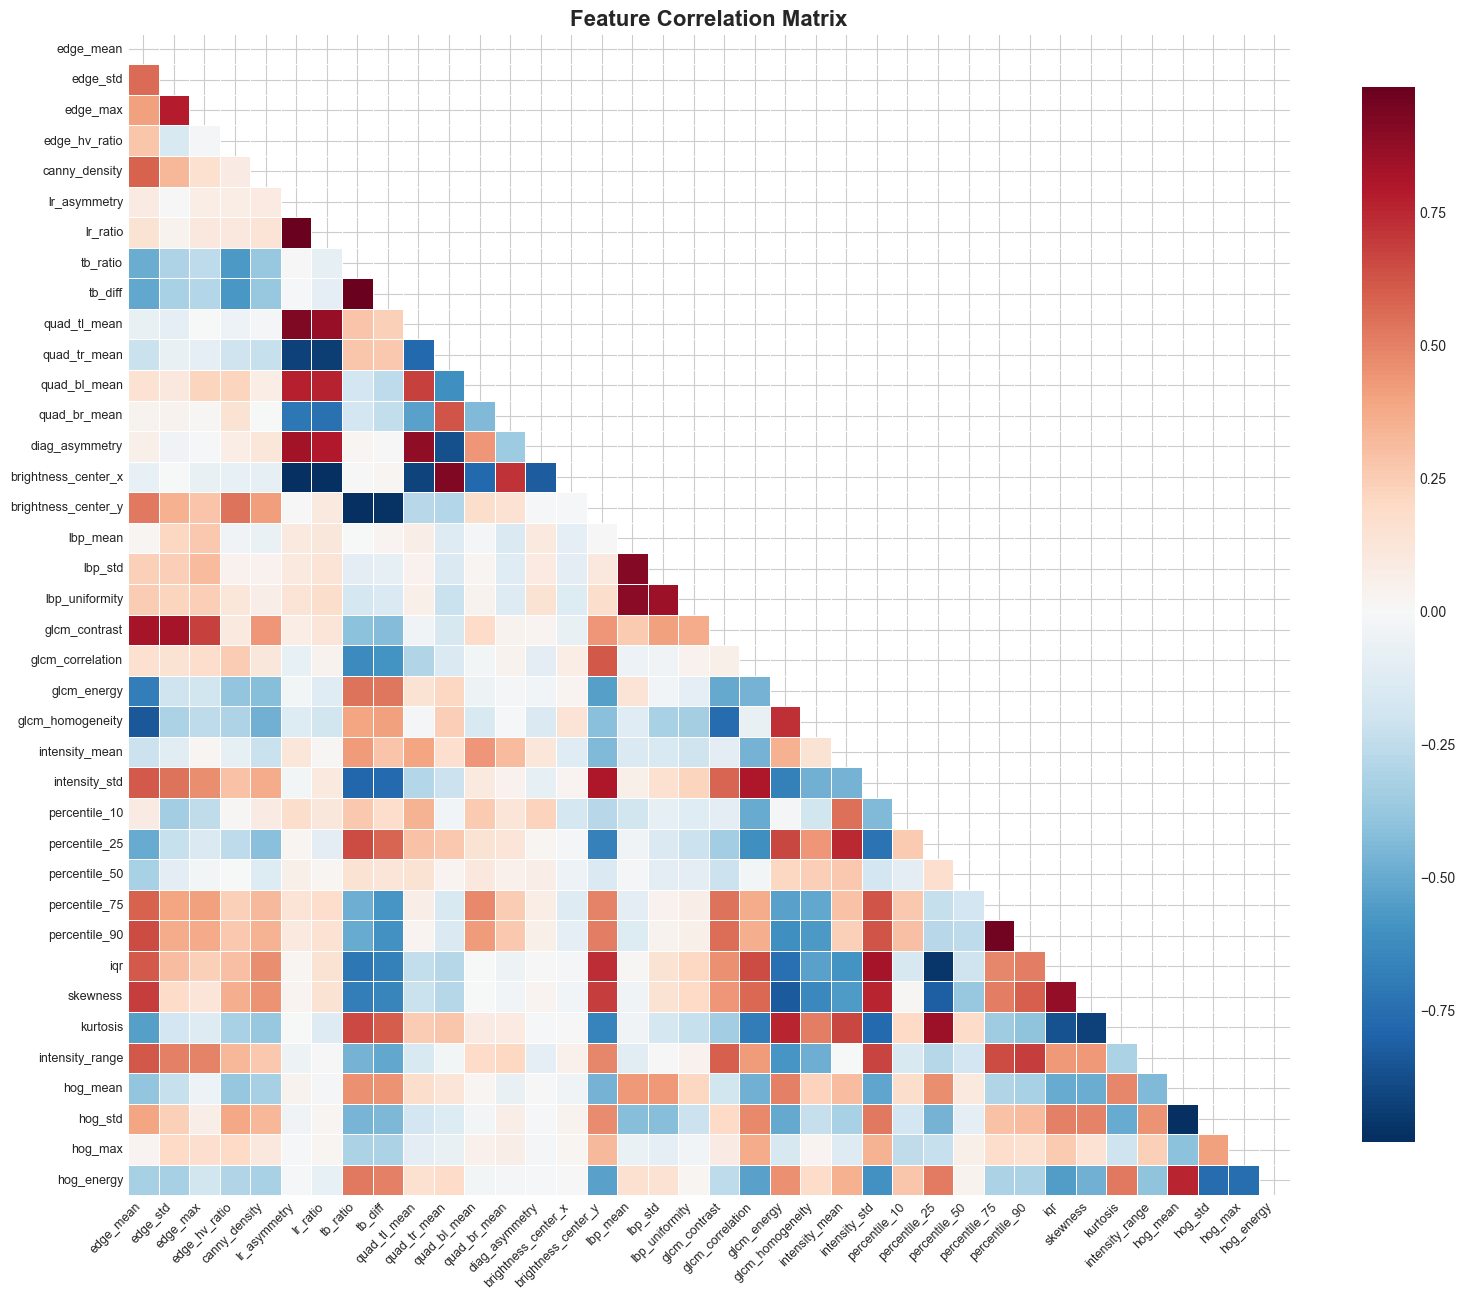

In [13]:
# Correlation matrix between features
plt.figure(figsize=(16, 14))

corr_matrix = df[feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


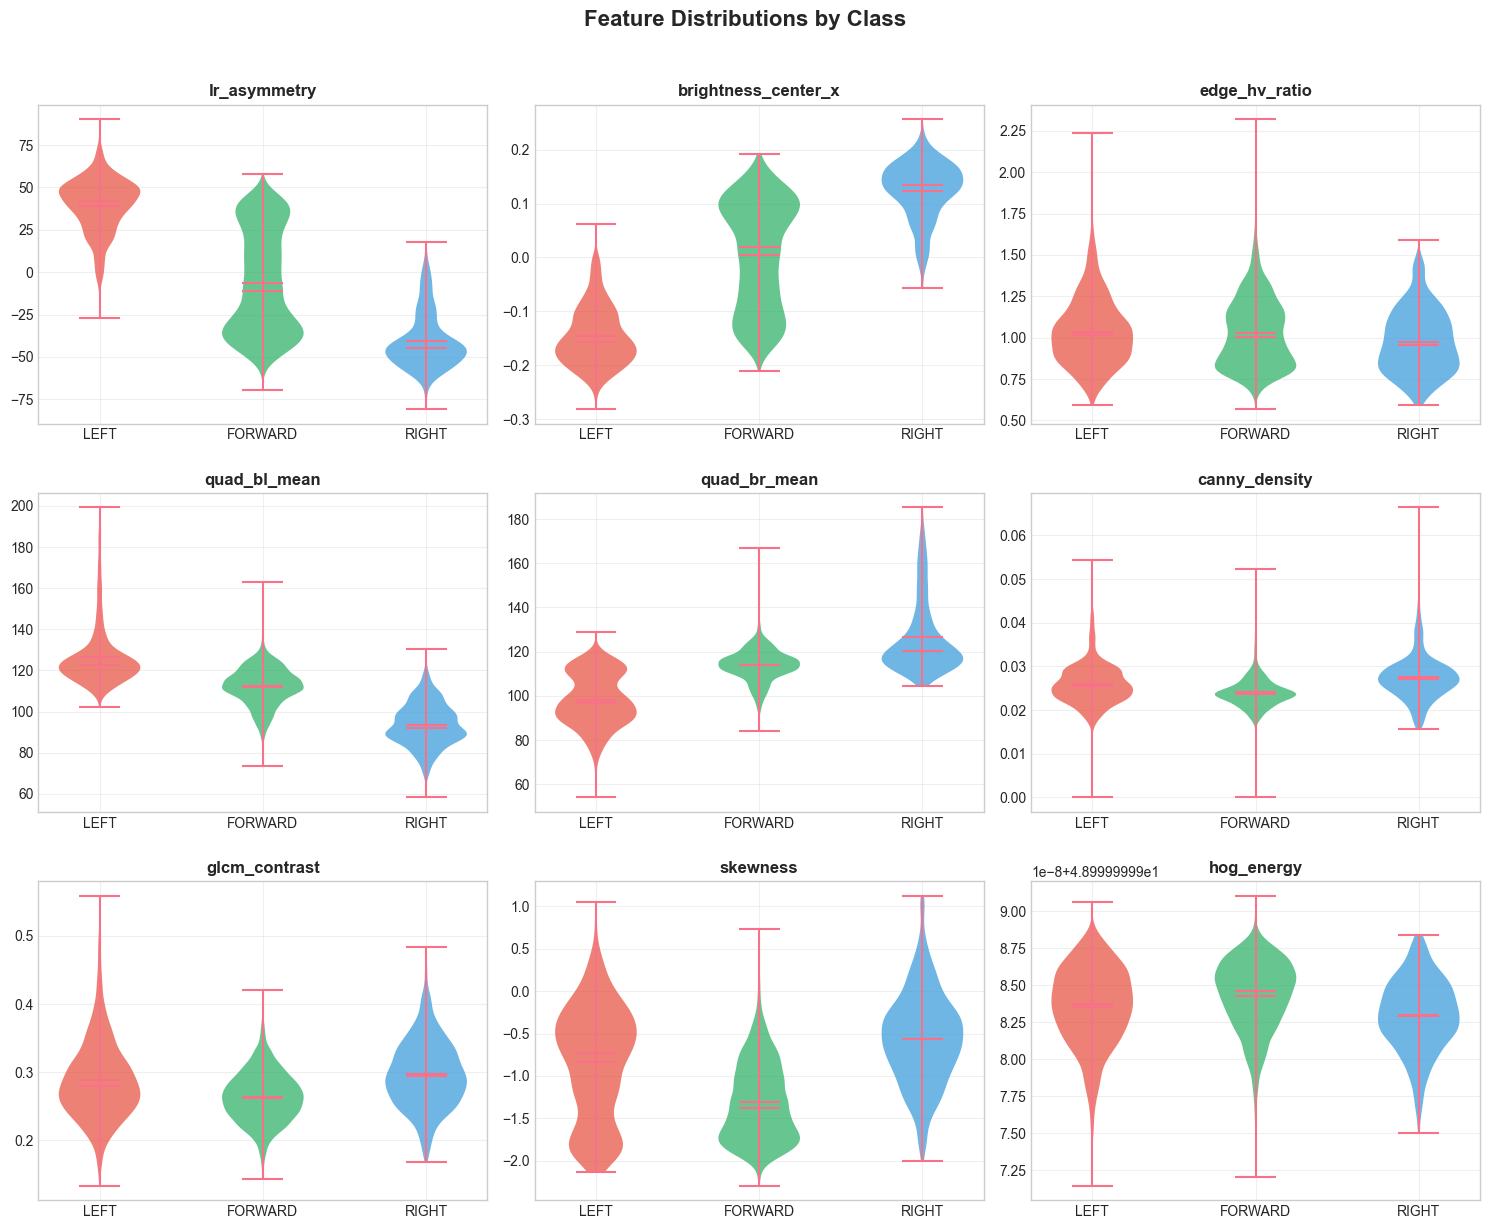

In [14]:
# Feature distributions by class - select key features for visualization
key_features = ['lr_asymmetry', 'brightness_center_x', 'edge_hv_ratio', 
                'quad_bl_mean', 'quad_br_mean', 'canny_density',
                'glcm_contrast', 'skewness', 'hog_energy']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for ax, feat in zip(axes, key_features):
    # Create violin plot
    parts = ax.violinplot([df[df['label'] == cls][feat].values for cls in CLASSES],
                          positions=range(len(CLASSES)), showmeans=True, showmedians=True)
    
    # Color the violins
    for i, (body, cls) in enumerate(zip(parts['bodies'], CLASSES)):
        body.set_facecolor(CLASS_COLORS[cls])
        body.set_alpha(0.7)
    
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels([c.upper() for c in CLASSES])
    ax.set_title(feat, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [15]:
# Most discriminative features using ANOVA F-scores
X_features = df[feature_cols].values
y_encoded = LabelEncoder().fit_transform(df['label'])

# Compute F-scores
f_scores, p_values = f_classif(X_features, y_encoded)

# Also compute mutual information
mi_scores = mutual_info_classif(X_features, y_encoded, random_state=42)

# Create ranking DataFrame
ranking_df = pd.DataFrame({
    'Feature': feature_cols,
    'F-Score': f_scores,
    'p-value': p_values,
    'Mutual Information': mi_scores
}).sort_values('F-Score', ascending=False)

print("Top 15 Most Discriminative Features (by F-Score):\n")
ranking_df.head(15)


Top 15 Most Discriminative Features (by F-Score):



,Feature,F-Score,p-value,Mutual Information
6,lr_ratio,3161.981248,0.000000e+00,0.274708
14,brightness_center_x,2927.461529,0.000000e+00,0.279327
11,quad_bl_mean,2926.209548,0.000000e+00,0.245705
12,quad_br_mean,2796.345984,0.000000e+00,0.233210
5,lr_asymmetry,2794.844764,0.000000e+00,0.278977
10,quad_tr_mean,1774.608920,0.000000e+00,0.175603
9,quad_tl_mean,1409.266998,0.000000e+00,0.161634
31,skewness,1227.291905,0.000000e+00,0.116044
30,iqr,942.703341,0.000000e+00,0.103264
0,edge_mean,839.947013,0.000000e+00,0.078732


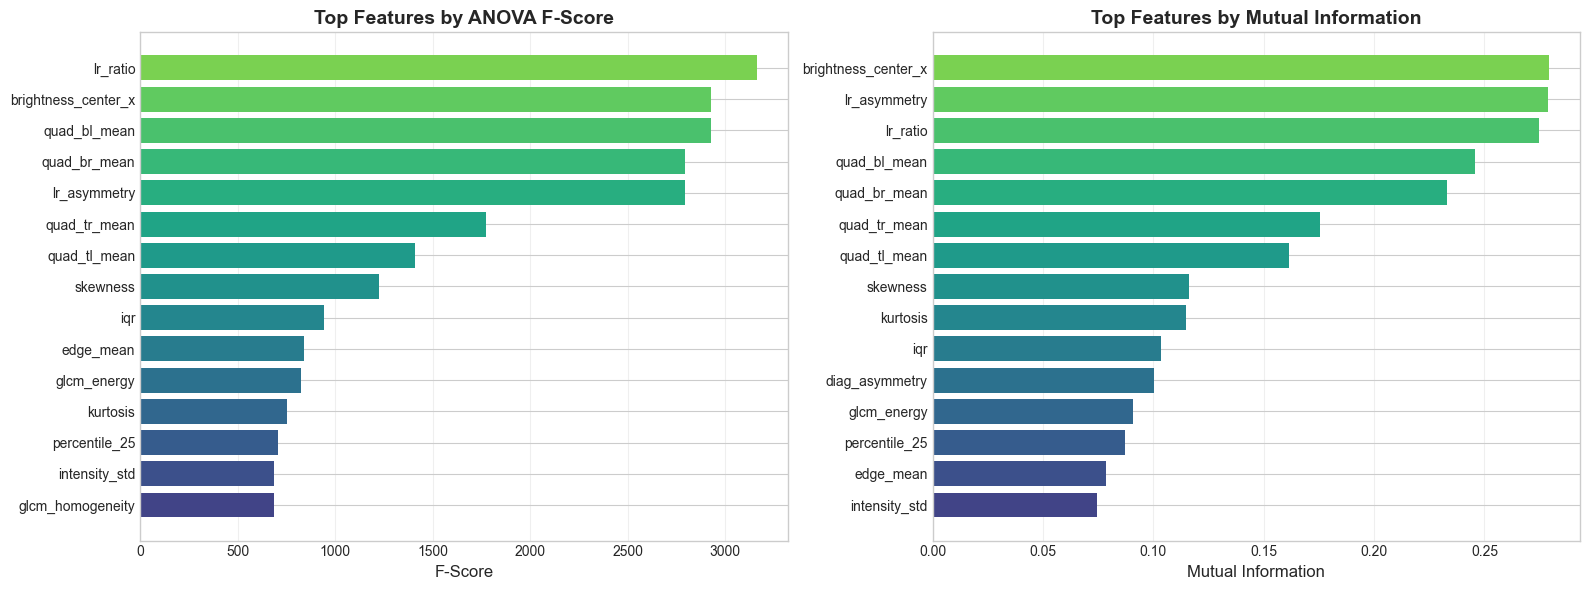

In [16]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F-Score bar chart
top_n = 15
top_features = ranking_df.head(top_n)
colors = plt.cm.viridis(np.linspace(0.8, 0.2, top_n))

axes[0].barh(range(top_n), top_features['F-Score'].values, color=colors)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('F-Score', fontsize=12)
axes[0].set_title('Top Features by ANOVA F-Score', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Mutual Information bar chart
mi_sorted = ranking_df.sort_values('Mutual Information', ascending=False).head(top_n)
axes[1].barh(range(top_n), mi_sorted['Mutual Information'].values, color=colors)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(mi_sorted['Feature'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Mutual Information', fontsize=12)
axes[1].set_title('Top Features by Mutual Information', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [17]:
# PCA visualization using engineered features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance by first 3 PCs: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  PC3: {pca.explained_variance_ratio_[2]:.2%}")


Explained variance by first 3 PCs: 60.85%
  PC1: 32.88%
  PC2: 17.79%
  PC3: 10.18%


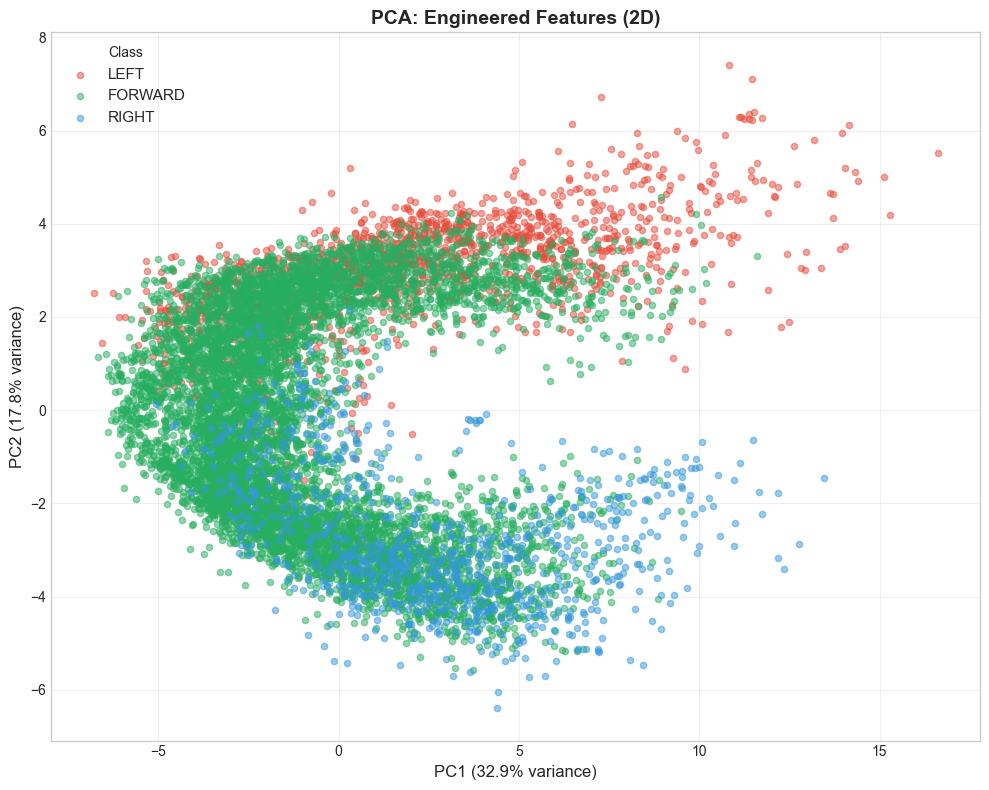

In [18]:
# PCA 2D scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

for cls in CLASSES:
    mask = df['label'] == cls
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.5, s=20)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('PCA: Engineered Features (2D)', fontsize=14, fontweight='bold')
ax.legend(title='Class', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# t-SNE visualization using engineered features
print("Fitting t-SNE (this may take a minute)...")

# Subsample for speed if needed
n_samples_tsne = min(3000, len(X_scaled))
np.random.seed(42)
indices = np.random.choice(len(X_scaled), n_samples_tsne, replace=False)

X_subset = X_scaled[indices]
y_subset = df['label'].values[indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_subset)
print("t-SNE complete!")


Fitting t-SNE (this may take a minute)...
t-SNE complete!


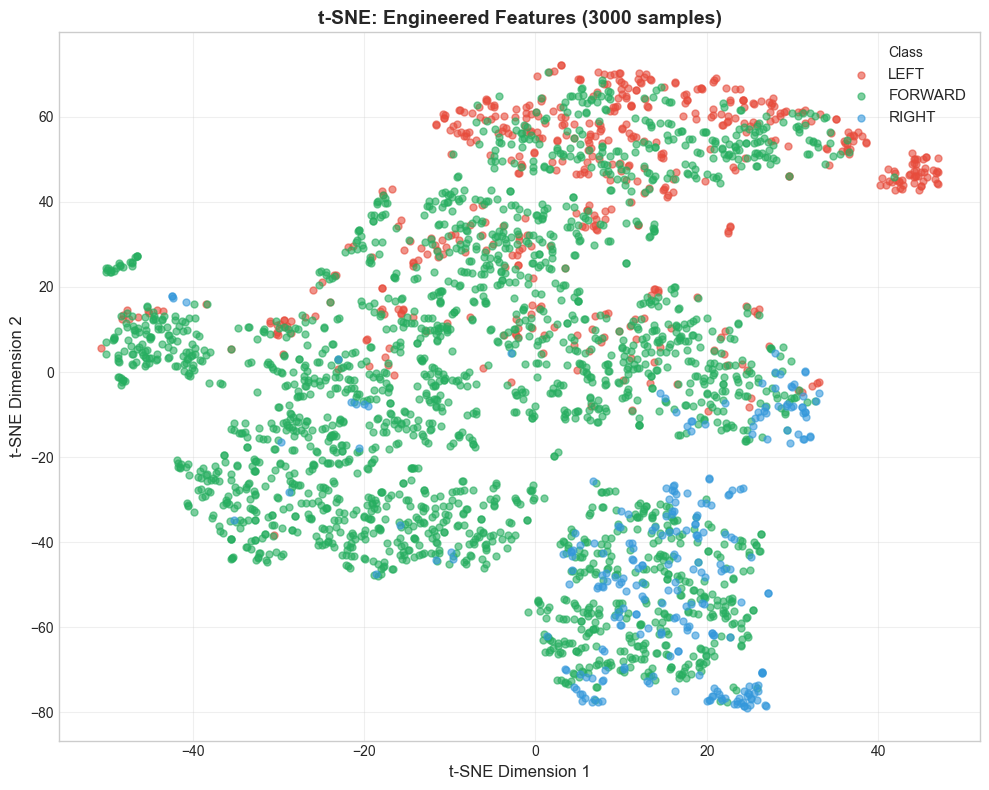

In [23]:
# t-SNE scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

for cls in CLASSES:
    mask = y_subset == cls
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.6, s=25)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f't-SNE: Engineered Features ({n_samples_tsne} samples)', fontsize=14, fontweight='bold')
ax.legend(title='Class', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


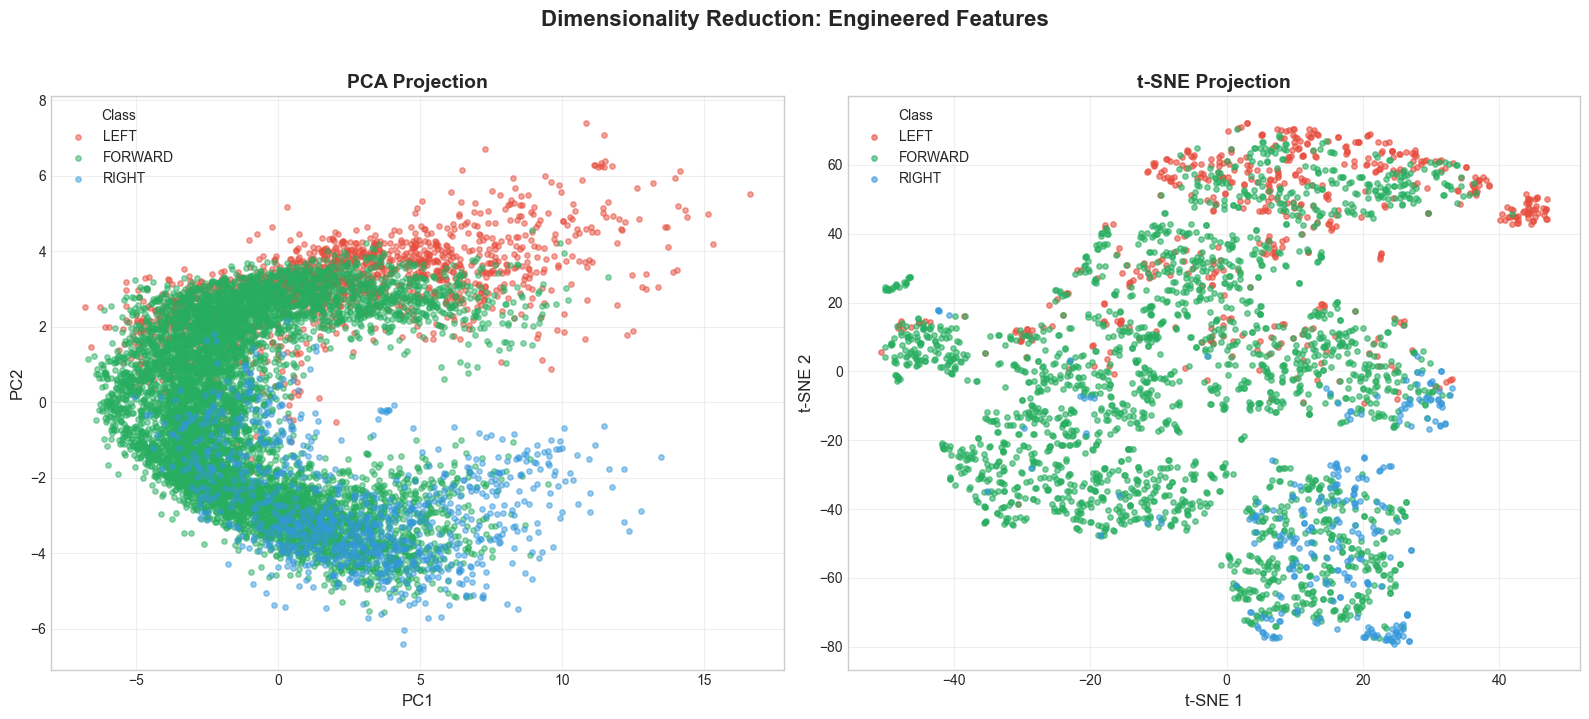

In [24]:
# Compare: PCA vs t-SNE side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA
for cls in CLASSES:
    mask = df['label'] == cls
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.5, s=15)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('PCA Projection', fontsize=14, fontweight='bold')
axes[0].legend(title='Class')
axes[0].grid(True, alpha=0.3)

# t-SNE
for cls in CLASSES:
    mask = y_subset == cls
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.6, s=15)
axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].set_title('t-SNE Projection', fontsize=14, fontweight='bold')
axes[1].legend(title='Class')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Dimensionality Reduction: Engineered Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [25]:
# Save engineered features for future use
output_path = Path('../data/engineered_features.csv')
df.to_csv(output_path, index=False)
print(f"Engineered features saved to: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Features: {len(feature_cols)}")
print(f"  Samples: {len(df)}")


Engineered features saved to: ../data/engineered_features.csv
  Shape: (9900, 39)
  Features: 38
  Samples: 9900


---
## Summary

This notebook engineered **{n_features}** features from the raw steering images across 5 categories:

### Feature Categories:
1. **Edge-Based Features** (5): Sobel statistics, horizontal/vertical edge ratio, Canny density
2. **Spatial/Region Features** (11): Left-right asymmetry, quadrant means, brightness center
3. **Texture Features** (7): LBP statistics, GLCM properties (contrast, correlation, energy, homogeneity)
4. **Histogram Features** (11): Percentiles, skewness, kurtosis, intensity statistics
5. **Gradient Features** (4): HOG descriptor statistics

### Key Findings:
- The **left-right asymmetry** and **brightness center** features are likely strong predictors for steering direction
- Spatial features capture the intuitive notion that left-turn images have different left/right brightness patterns
- Edge features may help detect lane markings and road boundaries
- The engineered features provide a more interpretable representation than raw pixels

### Output:
- Feature DataFrame saved to `data/engineered_features.csv` for use in model training
